#### Dataset: data3d.csv
#### Requirement:
* Read dataset
* Pre-processing data
* Use K-means clustering algorithm to cluster 3D points in data3D.csv

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
findspark.init()

In [3]:
import pyspark
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler

from pyspark.ml.clustering import KMeans

In [5]:
spark = SparkSession.builder.appName('kmeans_3D_point').getOrCreate()

In [6]:
# Load data
data = spark.read.csv("../../Data/data3D.csv", header=True, inferSchema=True)

In [7]:
data = data.select(['x', 'y', 'z'])

In [8]:
data.show(3)

+-----------------+------------------+------------------+
|                x|                 y|                 z|
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328| 8.963324308916228|
|5.005396944639823|-9.301070062115645| 10.35473056351597|
+-----------------+------------------+------------------+
only showing top 3 rows



### Format from data

In [9]:
vec_assembler = VectorAssembler(inputCols=data.columns, outputCol='features')

In [10]:
final_data = vec_assembler.transform(data)

### Scale the Data

In [11]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

In [12]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [13]:
# Normalize each feature to have unit standard deviation
final_data = scalerModel.transform(final_data)

In [14]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042428,-1.1300631023636816]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055376,-1.321371532702518,1.398892340103383]   |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |

### Train the Model and Evaluate

In [15]:
# Select k with minimun WSSSE: k between 2-10
k_list = []
wssse_list = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(final_data)
    wssse = model.summary.trainingCost
    k_list.append(k)
    wssse_list.append(wssse)
    print('With k=', k, "Set Sum of Squared Errors=", str(wssse))

With k= 2 Set Sum of Squared Errors= 2113156.7860371014
With k= 3 Set Sum of Squared Errors= 297656.40920043184
With k= 4 Set Sum of Squared Errors= 146718.50452180803
With k= 5 Set Sum of Squared Errors= 142633.18547524398
With k= 6 Set Sum of Squared Errors= 68625.36421980642
With k= 7 Set Sum of Squared Errors= 66275.37610393483
With k= 8 Set Sum of Squared Errors= 62138.96631402972
With k= 9 Set Sum of Squared Errors= 60117.8755183935
With k= 10 Set Sum of Squared Errors= 57323.221960775394


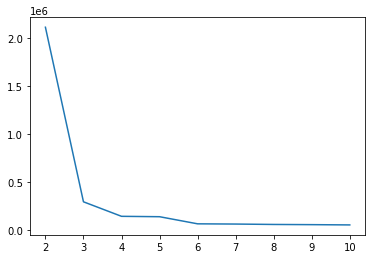

In [16]:
plt.plot(k_list, wssse_list)
plt.show()

Chọn k=5

In [17]:
# Train a k-means model
kmeans = KMeans(featuresCol='scaledFeatures', k=5)
model = kmeans.fit(final_data)

In [18]:
# Evaluate clustering by computing within Set Sum of Squared Errors
wssse = model.summary.trainingCost
print("With Set Sum of Squared Errors=", str(wssse))

With Set Sum of Squared Errors= 142633.18547524395


In [19]:
# Show the result
centers = model.clusterCenters()
print('Cluster Centers:')
for center in centers:
    print(center)

Cluster Centers:
[-0.45182036  1.15367577  0.72369935]
[ 0.60628338 -1.22598127  1.45407858]
[ 0.77554585 -0.80820119 -1.03388802]
[-1.59030525  0.93719373  0.31581855]
[ 0.89108349 -1.22781807  1.47991939]


In [20]:
predictions = model.transform(final_data)

In [21]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         2|
|         4|
|         4|
|         4|
|         3|
+----------+
only showing top 5 rows



In [22]:
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1| 99750|
|         3|199983|
|         4|100250|
|         2|400000|
|         0|200017|
+----------+------+



In [23]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [24]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042428,-1.1300631023636816]|
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |[0.7941127247055376,-1.321371532702518,1.398892340103383]   |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070062115645,10.35473056351597] |

In [25]:
temp = final_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [26]:
temp.show(3)

+------------------+-------------------+-------------------+
|                _1|                 _2|                 _3|
+------------------+-------------------+-------------------+
|1.0159673512169785|-0.8133579916042428|-1.1300631023636816|
|0.7941127247055376| -1.321371532702518|  1.398892340103383|
|0.9004347126254749|-1.1901880174546229|  1.616046989924021|
+------------------+-------------------+-------------------+
only showing top 3 rows



In [27]:
temp = temp.withColumn('row_index', monotonically_increasing_id())
data_result = data_result.withColumn('row_index', monotonically_increasing_id())
temp = temp.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")
temp.show(3)

+------------------+-------------------+-------------------+----------+
|                _1|                 _2|                 _3|prediction|
+------------------+-------------------+-------------------+----------+
|1.0159673512169785|-0.8133579916042428|-1.1300631023636816|         2|
|0.7941127247055376| -1.321371532702518|  1.398892340103383|         4|
|0.9004347126254749|-1.1901880174546229|  1.616046989924021|         4|
+------------------+-------------------+-------------------+----------+
only showing top 3 rows



In [28]:
temp = temp.select(col("_1").alias("x_scale"), col("_2").alias("y_scale"),col("_3").alias("z_scale"), "prediction")
df = temp.toPandas()

In [29]:
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1,2
0,-0.451820,1.153676,0.723699
1,0.606283,-1.225981,1.454079
2,0.775546,-0.808201,-1.033888
3,-1.590305,0.937194,0.315819
4,0.891083,-1.227818,1.479919


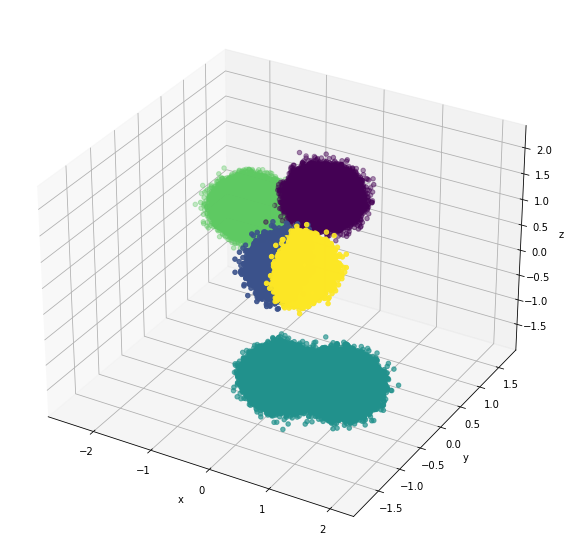

In [30]:
threedee = plt.figure(figsize=(12, 10)).gca(projection='3d')
threedee.scatter(df.x_scale, df.y_scale, df.z_scale, c=df.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')

plt.show()

### Combine results

In [31]:
final_data = final_data.withColumn('row_index', monotonically_increasing_id())
temp = temp.withColumn('row_index', monotonically_increasing_id())
final_data = final_data.join(temp, on=["row_index"]).sort("row_index").drop("row_index")
temp.show(3)

+------------------+-------------------+-------------------+----------+---------+
|           x_scale|            y_scale|            z_scale|prediction|row_index|
+------------------+-------------------+-------------------+----------+---------+
|1.0159673512169785|-0.8133579916042428|-1.1300631023636816|         2|        0|
|0.7941127247055376| -1.321371532702518|  1.398892340103383|         4|        1|
|0.9004347126254749|-1.1901880174546229|  1.616046989924021|         4|        2|
+------------------+-------------------+-------------------+----------+---------+
only showing top 3 rows



In [32]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|x                |y                 |z                 |features                                                 |scaledFeatures                                              |x_scale           |y_scale            |z_scale            |prediction|
+-----------------+------------------+------------------+---------------------------------------------------------+------------------------------------------------------------+------------------+-------------------+-------------------+----------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|[1.0159673512169785,-0.8133579916042428,-1.1300631023636816]|1.0159673512169785|-0.8133579916042428|-1.1300631023636816|2         |
|4.414367138